In [6]:
import os
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
os.makedirs("data", exist_ok=True)
os.makedirs("outputs", exist_ok=True)
os.makedirs("charts", exist_ok=True)

In [8]:
# Fetch Bitcoin (BTC-USD) data from 2020–2023
btc = yf.download("BTC-USD", start="2020-01-01", end="2023-12-31")

# Reset index to have Date column
btc.reset_index(inplace=True)

# Save raw data
btc.to_csv("data/bitcoin_data.csv", index=False)

C:\Users\USER\AppData\Local\Temp\ipykernel_24444\1571193111.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", start="2020-01-01", end="2023-12-31")
[*********************100%***********************]  1 of 1 completed


In [9]:
# 🔧 Fix column names (remove MultiIndex issue if present)
btc.columns = [col[0] if isinstance(col, tuple) else col for col in btc.columns]

# Intraday return %
btc["Return_pct"] = btc["Close"].pct_change() * 100

# Volume z-score
btc["Volume_zscore"] = (btc["Volume"] - btc["Volume"].mean()) / btc["Volume"].std()

# Flag anomalies (price > 2σ or volume spike > 2σ)
btc["Price_Anomaly"] = np.where(np.abs(btc["Return_pct"]) > 2*btc["Return_pct"].std(), 1, 0)
btc["Volume_Anomaly"] = np.where(np.abs(btc["Volume_zscore"]) > 2, 1, 0)

# Combined anomaly
btc["Anomaly_Flag"] = np.where((btc["Price_Anomaly"]==1) & (btc["Volume_Anomaly"]==1), 1, 0)

In [15]:
# 📌 Get all anomaly rows
anomalies = btc[btc["Anomaly_Flag"] == 1][["Date", "Close", "Volume", "Return_pct"]]

# Display
print("📌 Total anomalies detected:", anomalies.shape[0])
print(anomalies)

# Count anomalies
num_anomalies = btc["Anomaly_Flag"].sum()
print(f"✅ Total Anomaly Days Detected: {num_anomalies}")

📌 Total anomalies detected: 18
           Date         Close        Volume  Return_pct
72   2020-03-13   5563.707031   74156772075   11.928067
351  2020-12-17  22805.162109   71378606374    7.013245
371  2021-01-06  36824.363281   75289433811    8.331071
376  2021-01-11  35566.656250  123320567399   -7.273316
386  2021-01-21  30825.699219   75643067688  -13.283684
387  2021-01-22  33005.761719   77207272511    7.072224
393  2021-01-28  33466.097656   76517157706    9.968113
404  2021-02-08  46196.464844  101467222687   18.746474
419  2021-02-23  48824.425781  106102492824   -9.930199
473  2021-04-18  56216.183594   97468872758   -7.362155
497  2021-05-12  49150.535156   75215403907  -13.321745
504  2021-05-19  37002.441406  126358098747  -13.766123
505  2021-05-20  40782.738281   88281943359   10.216344
506  2021-05-21  37304.691406   82051616861   -8.528233
508  2021-05-23  34770.582031   78469274361   -7.368937
1042 2022-11-08  18541.271484  118992465607  -10.006132
1043 2022-11-09  

In [11]:
btc.to_csv("outputs/anomalies_btc.csv", index=False)

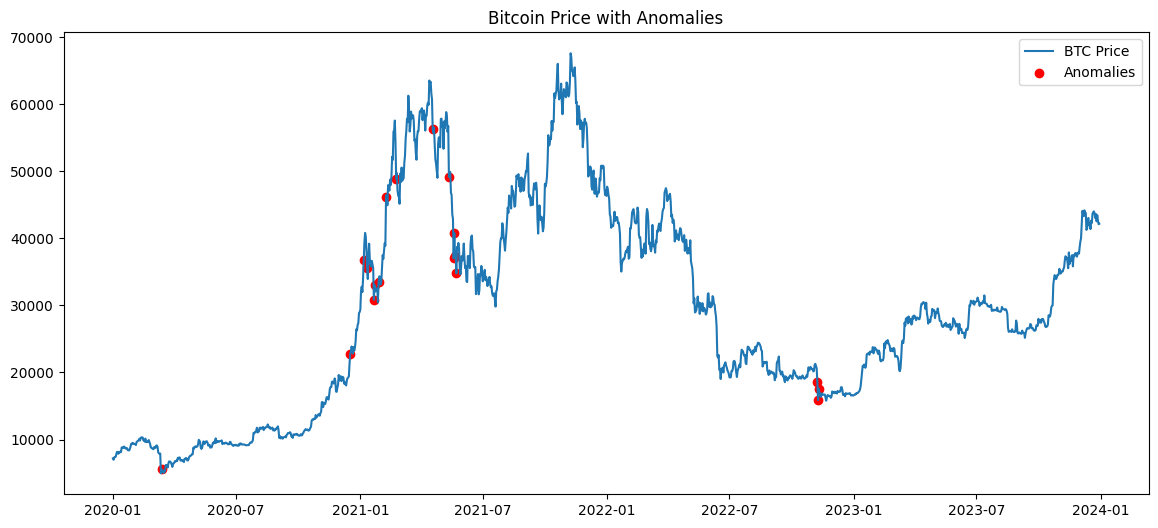

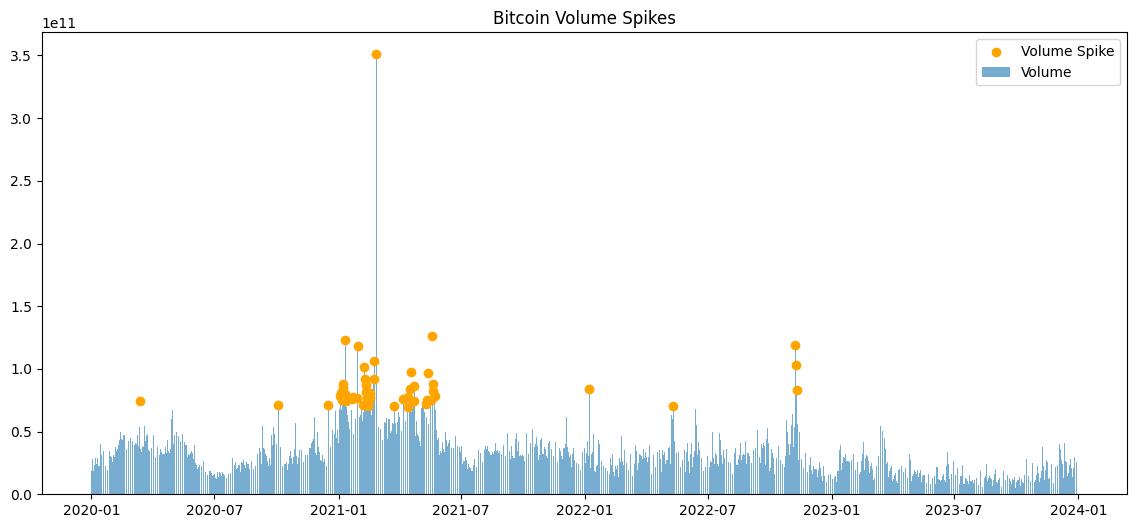

In [12]:
# Price chart with anomalies
plt.figure(figsize=(14,6))
plt.plot(btc["Date"], btc["Close"], label="BTC Price")
plt.scatter(btc.loc[btc["Anomaly_Flag"]==1, "Date"], btc.loc[btc["Anomaly_Flag"]==1, "Close"], 
            color="red", label="Anomalies")
plt.legend()
plt.title("Bitcoin Price with Anomalies")
plt.savefig("charts/anomalies_chart.png")
plt.show()

# Volume chart with spikes
plt.figure(figsize=(14,6))
plt.bar(btc["Date"], btc["Volume"], alpha=0.6, label="Volume")
plt.scatter(btc.loc[btc["Volume_Anomaly"]==1, "Date"], btc.loc[btc["Volume_Anomaly"]==1, "Volume"], 
            color="orange", label="Volume Spike")
plt.legend()
plt.title("Bitcoin Volume Spikes")
plt.savefig("charts/volume_chart.png")
plt.show()

In [13]:
max_volume_row = btc.loc[btc["Volume"].idxmax()]

print("📌 Largest Volume Spike:")
print(f"Date: {max_volume_row['Date'].date()}")
print(f"Closing Price: ${max_volume_row['Close']:.2f}")
print(f"Volume: {max_volume_row['Volume']:,}")

📌 Largest Volume Spike:
Date: 2021-02-26
Closing Price: $46339.76
Volume: 350,967,941,479
